# Практическое занятие

В рамках данного демо будем работать с синтетическим минибелковым ингибитором LCB3:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7857403/pdf/370_426.pdf

Структура комплекса LCB3 с в контакте RBD доменом коронавируса:

https://www.rcsb.org/structure/7JZM

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

%matplotlib inline
plt.ion()

In [ ]:
! wget https://files.rcsb.org/download/7JZM.pdb # Скачаем файл со структурой

--2025-04-16 08:19:27--  https://files.rcsb.org/download/7JZM.pdb
Resolving files.rcsb.org (files.rcsb.org)... 3.169.36.56, 3.169.36.124, 3.169.36.123, ...
Connecting to files.rcsb.org (files.rcsb.org)|3.169.36.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7JZM.pdb’

7JZM.pdb                [   <=>              ] 292.04K   638KB/s    in 0.5s    

2025-04-16 08:19:29 (638 KB/s) - ‘7JZM.pdb’ saved [299052]



Для визуализации можно использовать как и десктопные приложения, такие как PyMOL или Chimera. На сайте rcsb также присутствует интерактивный viewer трехмерных структур. В питоновских ноутбуках, однако, могут пригодиться адаптированные библиотеки, например nglview или py3Dmol.

In [ ]:
!pip install py3Dmol
import py3Dmol

In [ ]:
p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')

p.addModel(open('/content/7JZM.pdb','r').read(),'pdb') # добавить модель из файла

p.setStyle({'cartoon': {'color':'green'}}) # отобразить все в виде cartoon и покрасить в зеленый
p.setStyle({'chain': 'A'}, {'cartoon': {'color': 'blue'}})

p.zoomTo() # центрировать структуру

p.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# раскрасим отдельные остатки
residues = [420, 403, 417, 505]
for res in residues:
    p.setStyle({'chain': 'B', 'resi': res}, {
        'cartoon': {'color': 'red'},
        'stick': {'colorscheme': 'redCarbon'}
    })

p.zoomTo()
p.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
view.addModel(open('/content/7JZM.pdb','r').read(),'pdb')
view.setStyle({'cartoon': {'color':'green'}})
view.setStyle({'chain': 'A'}, {'stick': {'color': 'blue'}})

# Подсветим остатки из цепи А которые находится в радиусе 5 Ангстрем от остатков 403, 420, 417, 505 из цепи B
view.addStyle(
    {
        'and': [
            {'within': {
                'distance': 5,
                'sel': {
                    'or': [
                        {'resi': 403, 'chain': 'B'},
                        {'resi': 420, 'chain': 'B'},
                        {'resi': 417, 'chain': 'B'},
                        {'resi': 505, 'chain': 'B'}
                    ]
                }
            }},
            {'chain': 'A'}
        ]
    },
    {
        'stick': {
            'colorscheme': 'redCarbon'
        }
    }
)

view.zoomTo() # Center the structure
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# ProteinMPNN

In [ ]:
!mkdir INPUT/
!mkdir OUTPUT_MPNN/
!mv 7JZM.pdb INPUT/

Устанавливаем ProteinMPNN локально.

In [ ]:
!git clone https://github.com/dauparas/ProteinMPNN

Cloning into 'ProteinMPNN'...
remote: Enumerating objects: 634, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 634 (delta 185), reused 155 (delta 155), pack-reused 394 (from 1)
Receiving objects: 100% (634/634), 119.91 MiB | 21.77 MiB/s, done.
Resolving deltas: 100% (285/285), done.


Запустим ProteinMPNN для редизайна последовательности минипротеина.

In [ ]:
%%bash

python ProteinMPNN/helper_scripts/parse_multiple_chains.py --input_path=INPUT/ --output_path=parsed_chains

python ProteinMPNN/helper_scripts/assign_fixed_chains.py --input_path=parsed_chains --output_path=assigned_chains --chain_list "A"

python ProteinMPNN/protein_mpnn_run.py \
        --jsonl_path parsed_chains \
        --chain_id_jsonl assigned_chains \
        --out_folder OUTPUT_MPNN \
        --num_seq_per_target 20 \
        --sampling_temp "0.1" \
        --seed 42 \
        --batch_size 1

----------------------------------------
fixed_positions_jsonl is NOT loaded
----------------------------------------
pssm_jsonl is NOT loaded
----------------------------------------
omit_AA_jsonl is NOT loaded
----------------------------------------
bias_AA_jsonl is NOT loaded
----------------------------------------
tied_positions_jsonl is NOT loaded
----------------------------------------
bias by residue dictionary is not loaded, or not provided
----------------------------------------
discarded {'bad_chars': 0, 'too_long': 0, 'bad_seq_length': 0}
----------------------------------------
Number of edges: 48
Training noise level: 0.2A
Generating sequences for: 7JZM
20 sequences of length 258 generated in 61.1442 seconds


Попробуем посмотреть статистики по аминокислотам.

Необходимо построить ЛОГО и вывести частоты аминокислот.

In [ ]:
!pip install logomaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 72.6 MB/s eta 0:00:00


In [ ]:
import logomaker as lm

In [ ]:
with open('OUTPUT_MPNN/seqs/7JZM.fa', 'r') as f:
    raw_seqs = f.readlines()

In [ ]:
seqs[0][10]

'D'

In [ ]:
interface = [10, 33, 34, 30, 7]

# Достанем из .fa файла сами последовательности, без хедеров
seqs = [seq[:-1] for seq in raw_seqs if '>' not in seq]
print('There are %d sequences, all of length %d'%(len(seqs), len(seqs[0])))
interface_list = []
for seq in seqs:
  interface_list.append(''.join([aa for i, aa in enumerate(seq) if i in interface]))

There are 21 sequences, all of length 64


In [ ]:
counts_mat = lm.alignment_to_matrix(interface_list)
counts_mat.head()

,A,D,E,I,K,L,Q,R,T
pos,,,,,,,,,
0,0,0,15,0,1,1,0,4,0
1,0,21,0,0,0,0,0,0,0
2,3,0,7,0,9,0,2,0,0
3,0,0,21,0,0,0,0,0,0
4,0,0,2,4,13,1,0,0,1


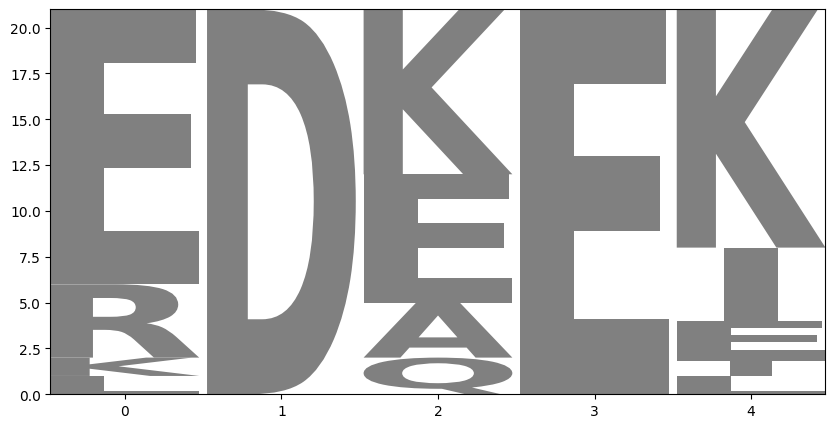

In [ ]:
lm.Logo(counts_mat, figsize=(10, 5))

Можем ли сказать, что определенные позиции имеют консервативные аминокислоты? Совпадают ли в этих позициях предложенные ProteinMPNN с изначальной последовательность минипротеина?

In [ ]:
 !pip install biopython

In [ ]:
from Bio import PDB
from Bio.PDB.Polypeptide import PPBuilder

parser = PDB.PDBParser()
pdb1 ='INPUT/7JZM.pdb'
main_structure = parser.get_structure("7JZM", pdb1)

target_seqs = []
ppb=PPBuilder()
for model in main_structure:
    for chain in model:
          for pp in ppb.build_peptides(chain):
              target_seqs.append(pp.get_sequence())

In [ ]:
len(target_seqs[1])

194

In [ ]:
res_match_count = np.zeros(64)
for i in range(64):
  for j in range(len(seqs)):
    if seqs[j][i] == target_seqs[0][i]:
      res_match_count[i] += 1

Text(0, 0.5, 'Sequence recovery')

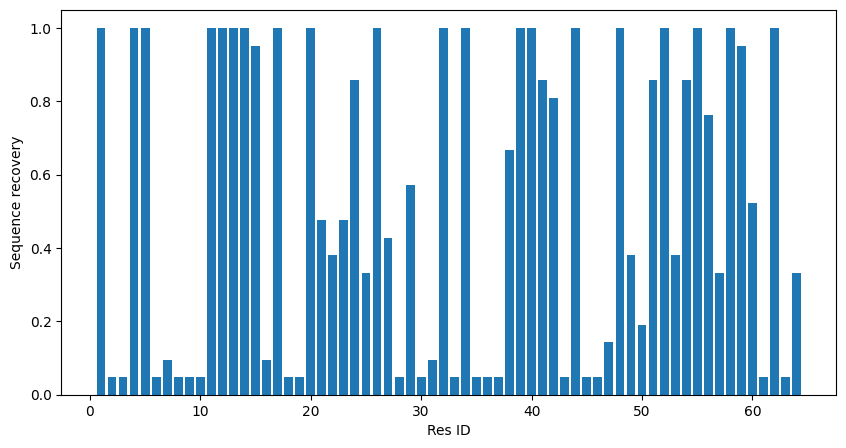

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(1,len(target_seqs[0])+1),res_match_count / len(seqs))
plt.xlabel('Res ID')
plt.ylabel('Sequence recovery')

# RFDiffusion

Основной колаб для работы с пайплайном:
* https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/rf/examples/diffusion.ipynb#scrollTo=tVAE0BrnZoRR

Репозиторий с моделью:
* https://github.com/RosettaCommons/RFdiffusion/tree/main/scripts

RFDiffusionAA - all-atom модель, может обрабатывать малые молекулы и ДНК/РНК:
* https://github.com/baker-laboratory/rf_diffusion_all_atom

# Supplementary Materials


---
## Hotspot prediction

MaSIF:
* https://github.com/LPDI-EPFL/masif

PeSTO:
* https://github.com/LBM-EPFL/PeSTo
* Web: https://pesto.epfl.ch/

ScanNet:

* https://github.com/ScanNet/ScanNet

---
## Folding

ColabFold - репозиторий с большим число колабовских ноутбуков для фолдинга:
* https://github.com/sokrypton/ColabFold

AlphaFold 2 отдельно:
* https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb#scrollTo=G4yBrceuFbf3

AlphaFold 2 локально:
* https://github.com/YoshitakaMo/localcolabfold


---
## Protein design

ColabDesign - большой репозиторий различных моделей в колабе для дизайна белковых молекул:
* https://github.com/sokrypton/ColabDesign

AFDesign - отдельная модель из ColabDesign, проектирующая белки с применением AlphaFold 2:
* https://github.com/sokrypton/ColabDesign/tree/main/af

BindCraft - модификация AFDesign, специфично для генерации байндеров:
* https://github.com/martinpacesa/BindCraft

Chroma:
* https://github.com/generatebio/chroma